# Jobs and Tasks Dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import seaborn as sns

## Preparing the data

The dataset was prepared by Professor Squires and Catalina

In [3]:
path = Path('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina')

In [5]:
path.ls()

[PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/models'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/texts.csv'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/data_clas.pkl'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/labels1.csv'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/tasks1.csv'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/data_lm.pkl'),
 PosixPath('/home/jupyter/fastai-d1/mendes/data/job-tasks-catalina/data_save.pkl')]

In [7]:
# labels = pd.read_csv(path/'labels1.csv',header=None)
# tasks = pd.read_csv(path/'tasks1.csv',header=None)

# X_train, X_test, y_train, y_test, = train_test_split(tasks,labels, test_size=0.20, random_state=42)

# labels['validation'] = 0
# labels.loc[X_test.index,'validation'] = 1

# df=pd.concat([tasks,labels],axis=1,ignore_index=True)
# df.columns = ['tasks','labels','validation']
# df.to_csv(path/'texts.csv',index=False)

df=pd.read_csv(path/'texts.csv')
df.head(10)

,tasks,labels,validation
0,Direct or coordinate an organization's financi...,0,1
1,Appoint department heads or managers and assig...,0,0
2,Analyze operations to evaluate performance of ...,0,0
3,"Direct, plan, or implement policies, objective...",0,1
4,"Prepare budgets for approval, including those ...",0,0
5,"Confer with board members, organization offici...",0,0
6,Implement corrective action plans to solve org...,0,1
7,"Direct human resources activities, including t...",0,0
8,Establish departmental responsibilities and co...,0,0
9,"Preside over or serve on boards of directors, ...",0,0


In [11]:
print(df['tasks'][0])

Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency.


In [12]:
print(df['tasks'][500])

Prepare or file environmental certification applications.


In [13]:
print(df['tasks'][1000])

Identify methods for distributing purified wastewater into rivers, streams, or oceans.


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [14]:
bs=48

Now let's grab the full dataset for what follows.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [15]:
# data_lm = (TextList.from_csv(path, 'texts.csv', cols='tasks')
#                 .split_from_df(col=2)
#                 .label_for_lm()
#                 .databunch(bs=bs))
# data_lm.save('data_lm.pkl')

# print(type(data_lm))

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [31]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [32]:
# type(data_lm)

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [33]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [19]:
# learn.lr_find()
# learn.recorder.plot(skip_end=15)

In [20]:
#looking at the losses graph, more than 5 cycles, the model starts to overfit on the test validation
# learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

In [21]:
# learn.recorder.plot_losses()

In [22]:
#learn.save('fit_head')

In [23]:
# learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [24]:
# learn.unfreeze()
# learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [25]:
# learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [34]:
learn.load('fine_tuned');

In [35]:
TEXT = "Direct or coordinate an organization's financial"
N_WORDS = 40
N_SENTENCES = 2

In [37]:
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Direct or coordinate an organization's financial products , services , or operations . xxbos Schedule or confirm appointments for clients , patients , or family members . xxbos Maintain and update organization information technology applications and network systems systems . xxbos Update automated

Direct or coordinate an organization's financial products , services , or repairs . xxbos Mix and match colors of paint , stain , or varnish with oil or thinning and drying additives to obtain desired colors and consistencies . xxbos Prepare and maintain records


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [38]:
TEXT = "Write report about"
N_WORDS = 40
N_SENTENCES = 2

In [39]:
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Write report about a story 's information to the publisher . xxbos Compute taxes owed or prepare tax returns , ensuring compliance with payment , reporting , or other tax requirements . xxbos Cut , trim , bone , tie ,

Write report about personnel status , activity , , and other issues found in response to inspections or recommendations , and refer applicants to other departments , agencies , or institutions for improving service and equipment functioning . xxbos Remove broken limbs


In [40]:
# learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [41]:
# data_clas = (TextList.from_csv(path, 'texts.csv', cols='tasks')
#                 .split_from_df(col=2)
#                 .label_from_df(cols=1)
#                 .databunch(bs=bs))

# data_clas.save('data_clas.pkl')

In [42]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [43]:
# data_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

In [44]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

In [ ]:
# learn.recorder.plot_losses()

In [ ]:
# learn.save('first')

In [ ]:
# learn.load('first');

In [ ]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
# learn.recorder.plot_losses()

In [ ]:
# learn.save('second')

In [ ]:
# learn.load('second');

In [ ]:
# learn.freeze_to(-3)
# learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
# learn.recorder.plot_losses()

In [ ]:
# learn.save('third')

In [45]:
learn.load('third');

In [46]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.922762,1.421982,0.586541,00:27
1,0.876467,1.419512,0.591129,00:28


In [48]:
learn.predict(df['tasks'][0])

(Category 0,
 tensor(0),
 tensor([9.9046e-01, 5.9847e-03, 8.5802e-05, 3.2841e-04, 5.9937e-04, 6.7772e-05,
         1.7930e-06, 4.2834e-05, 1.0185e-04, 4.2109e-04, 8.1316e-06, 6.4257e-05,
         1.3853e-05, 2.0584e-04, 7.3074e-04, 1.7462e-04, 7.6478e-05, 2.4436e-04,
         5.9466e-05, 1.4304e-05, 1.9484e-05, 2.9892e-04]))

In [49]:
learn.predict("Help students to learn better")

(Category 9,
 tensor(9),
 tensor([1.1647e-02, 4.1846e-03, 2.4256e-02, 7.4654e-02, 1.9348e-01, 7.1778e-03,
         2.2032e-04, 7.6317e-02, 2.2894e-03, 5.0468e-01, 1.0307e-02, 1.8673e-03,
         2.9690e-05, 8.3130e-05, 3.5764e-03, 1.2846e-04, 2.5107e-03, 2.8712e-04,
         6.6962e-03, 5.8720e-02, 4.5153e-04, 1.6438e-02]))

In [50]:
#learn.recorder.plot_losses()

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

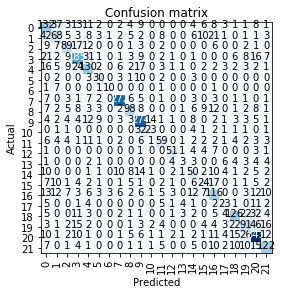

In [52]:
interp.plot_confusion_matrix()

In [53]:
mistakes = pd.DataFrame(interp.most_confused())
mistakes.columns = ['correct','predicted','times']
heat = mistakes.pivot_table(columns='correct',index='predicted',values='times')
mistakes.head()

,correct,predicted,times
0,19,20,46
1,1,0,42
2,0,1,37
3,10,9,32
4,18,20,32


In [54]:
interp.most_confused(min_val=20)

[(19, 20, 46),
 (1, 0, 42),
 (0, 1, 37),
 (10, 9, 32),
 (18, 20, 32),
 (3, 4, 31),
 (20, 19, 26),
 (4, 3, 24),
 (18, 19, 22),
 (19, 18, 22),
 (1, 16, 21),
 (3, 0, 21)]

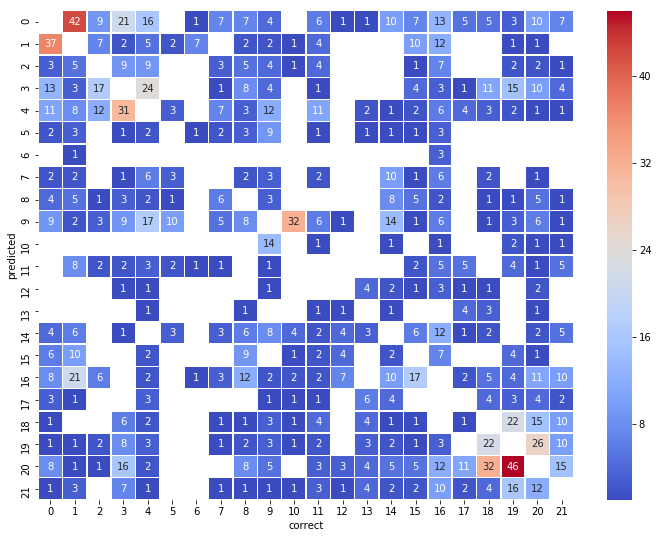

In [55]:
dims = (12,9)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(heat,annot=True,linewidth=0.5,cmap='coolwarm',ax=ax)